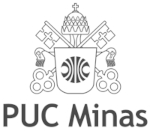

## Programa de Pós Graduação em Informática

### Disciplina: Natural Language Processing (NLP)

### Aluno: Felipe A. L. Reis

---
## Descrição do Modelo (BERT - Baseado Comunidade Kaggle).

O notebook foi baseado nas submissões abaixo do Kaggle, publicadas pela comunidade.

* https://www.kaggle.com/code/aruthart/submission, por [Arto](https://www.kaggle.com/aruthart);
* https://www.kaggle.com/code/aruthart/eda-and-baseline/notebook, por [Arto](https://www.kaggle.com/aruthart);
* https://www.kaggle.com/code/surilee/inference-bert-for-uspatents-deepshare, por [Suri_Lee](https://www.kaggle.com/surilee).
* https://www.kaggle.com/code/renokan/2-deberta-1-roberta-analysis-and-using/notebook, por [Anatoly Burenok](https://www.kaggle.com/renokan)
* https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference, por [Y.Nakama](https://www.kaggle.com/yasufuminakama)

Os pesos utilizados, já treinados, foram obtidos de https://www.kaggle.com/datasets/minegreen95/custom-bert-simple-deberta-v2-xlarge.

---

---
## Importação de Bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2
from nlputil import load_data, split_data, get_examples, do_lemma_stemmer, calcula_correlacao
from nlputil import pre_process_codes, pre_process_data_codes, calcula_correlacao

In [2]:
import os
import gc
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoConfig, AutoModel#, Trainer
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

---
## Aplicação de Pré Processamento Textual

In [3]:
data = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
codes = load_data('dicionario_dados/titles.csv')

codes = codes.drop(['subclass','group', 'main_group', 'section', 'class'], axis=1)

data.head()

id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00

In [4]:
data = pre_process_data_codes(data, codes)
data.head()

id     anchor                  target context  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst     A47   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00  A47   

                                               title  
0  furniture domestic articles or appliances coff...  
1  furniture domestic articles or appliances coff...  
2  furniture domestic articles or appliances coff...  
3  furniture domestic articles or appliances coff...  
4  furniture domestic articles or appliances coff...

In [5]:
data['text'] = data.anchor.values + '[sep]' + data.target.values + '[sep]' + data.title.values
data.head()

id     anchor                  target context  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst     A47   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00  A47   

                                               title  \
0  furniture domestic articles or appliances coff...   
1  furniture domestic articles or appliances coff...   
2  furniture domestic articles or appliances coff...   
3  furniture domestic articles or appliances coff...   
4  furniture domestic articles or appliances coff...   

                                                text  
0  abatement[sep]abatement of pollution[sep]furni...  
1  abatement[sep]act of abating[sep]furniture dom...  
2  abatement[sep]active catalyst[sep]furniture do...  
3  abatement[sep]eliminating process[sep]furnitur...  
4  abatement[sep]forest region[sep]furniture dome...

In [6]:
test = pre_process_data_codes(test, codes)
test.head()

id             anchor                         target context  \
0  4112d61851461f60           opc drum  inorganic photoconductor drum     G02   
1  5203a36c501f1b7c  generate in layer              generate by layer     G02   
2  7aa5908a77a7ec24         el display                   illumination     G02   
3  09e418c93a776564    adjust gas flow              altering gas flow     F23   
4  36baf228038e314b     lower trunnion                 lower locating     B60   

  code                                      title  
0  G02                                     optics  
1  G02                                     optics  
2  G02                                     optics  
3  F23  combustion apparatus combustion processes  
4  B60                        vehicles in general

In [7]:
test['text'] = test.anchor.values + '[sep]' + test.target.values + '[sep]' + test.title.values
test.head()

id             anchor                         target context  \
0  4112d61851461f60           opc drum  inorganic photoconductor drum     G02   
1  5203a36c501f1b7c  generate in layer              generate by layer     G02   
2  7aa5908a77a7ec24         el display                   illumination     G02   
3  09e418c93a776564    adjust gas flow              altering gas flow     F23   
4  36baf228038e314b     lower trunnion                 lower locating     B60   

  code                                      title  \
0  G02                                     optics   
1  G02                                     optics   
2  G02                                     optics   
3  F23  combustion apparatus combustion processes   
4  B60                        vehicles in general   

                                                text  
0  opc drum[sep]inorganic photoconductor drum[sep...  
1  generate in layer[sep]generate by layer[sep]op...  
2             el display[sep]illumination[sep]optics  
3  adjust gas flow[sep]altering gas flow[sep]comb...  
4  lower trunnion[sep]lower locating[sep]vehicles...

---
## Criação do Modelo

O modelo utilizando BERT (e sua variação DeBERTa) teve como objetivo analisar como aplicar tais métodos na solução do problemas de NLP. 
O modelo teve como objetivo avaliar apenas o desempenho possível de ser alcançado ao utilizar essas bibliotecas, quando pré-treinadas para a tarefa de análise de patentes.

Os valores pré-treinados foram indicados pela comunidade como "*baseline*" dos resultados esperados.

No notebook criado, foi recuperado um modelo pré-treinado, utilizando pesos obtidos de https://www.kaggle.com/datasets/minegreen95/custom-bert-simple-deberta-v2-xlarge. 

Nesse notebook, foram utilizadas redes [Transformers](https://huggingface.co/transformers/v4.8.2/model_doc/bert.html?highlight=berttokenizer) e o modelo [DeBERTa](https://huggingface.co/transformers/v4.8.2/model_doc/deberta_v2.html).
A rede recuperou pesos já treinados e produziu quatro predições diferentes, que foram combinadas em uma única previsão, responsável pelo resultado final do modelo.

#### Restrições

* O modelo atual utilizou os pesos do conjunto *bert-base-uncased* para testes locais. Os resultados obtidos nesta versão, fora do Kaggle, correspondem a apenas valores aleatórios (ao utilizar o DeBERTa na máquina local, o sistema aprensentava incompatibilidade de bibliotecas, sendo desenvolvido o restante do trabalho diretamente no Kaggle). 
* O código fonte existente no Kaggle está publicamente disponível em: https://www.kaggle.com/code/falreis/patent-bert/notebook.

Classe com parametrização do modelo.

In [8]:
class CONFIG_BERT:
    #model_id = 'microsoft/deberta-v3-large'
    #model_id = '../input/deberta-v2-xlarge'
    model_id = 'bert-base-uncased' #'bert-base-uncased'
    folds = 4
    batch_size = 128
    max_input_len = 130
    num_workers = 12

Definição de utilização de GPU ou CPU.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Criação de *tokenizer*, à partir do modelo pré-treinado.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG_BERT.model_id)
#model = AutoModelForSequenceClassification.from_pretrained(CONFIG_BERT.model_id).to(device)

Criação de classe com o *tokenizer* e as strings para utilização no modelo. 

In [11]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_len):        
        self.text = df.text.values.astype(str)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, i):
        inputs = self.text[i]
        
        inputs = self.tokenizer(inputs,
                                max_length = self.max_input_length,
                                padding    = 'max_length',
                                truncation = True)
        
        return torch.as_tensor(inputs['input_ids'], dtype=torch.long),\
               torch.as_tensor(inputs['token_type_ids'], dtype=torch.long),\
               torch.as_tensor(inputs['attention_mask'], dtype=torch.long)

Criação e configuração do modelo.

In [12]:
class BertSimple(nn.Module):
    def __init__(self, model_id):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_id)
        config.num_labels = 1
        
        self.base = AutoModelForSequenceClassification.from_config(config=config)
        
        dim = config.hidden_size
        self.dropout = nn.Dropout(p=0)
        self.cls = nn.Linear(dim,1)
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        base_output = self.base(input_ids      = input_ids, 
                                attention_mask = attention_mask,
                                token_type_ids = token_type_ids )

        output = base_output[0]
        return output
    
def valid_fn(valid_loader, model, device):
    model.eval()
    preds, labels = [], []
    
    for step, batch in enumerate(valid_loader):
        input_ids, token_type_ids, attention_mask = [i.to(device) for i in batch]
        
        with torch.no_grad():
            y_preds = model(input_ids, attention_mask, token_type_ids)
        preds.append(y_preds.to('cpu').numpy())
        
    predictions = np.concatenate(preds)
    
    return predictions

Predição de resultados.

In [13]:
def predict(df):
    predictions = []
    MMscaler = MinMaxScaler()
    te_dataset = TextDataset(df, tokenizer, CONFIG_BERT.max_input_len)

    te_dataloader = DataLoader(te_dataset,
                               batch_size  = CONFIG_BERT.batch_size,
                               shuffle     = False,
                               num_workers = CONFIG_BERT.num_workers, 
                               pin_memory  = True, 
                               drop_last   = False)

    for fold in tqdm(range(CONFIG_BERT.folds)):

        model = BertSimple(CONFIG_BERT.model_id)
        #state = torch.load('bert-base-uncased-best{}.pth'.format(fold))
        #model.load_state_dict(state['model'])
        model.to('cuda')

        outputs = valid_fn(te_dataloader, model, 'cuda')
        prediction = outputs.reshape(-1)
        predictions.append(MMscaler.fit_transform(prediction.reshape(-1,1)).reshape(-1))
        
    return predictions

### Similaridade no Treinamento

Calcula a similaridade no conjunto de treinamento, para avaliação dos resultados obtidos e comparação com os resultados previstos.

*Como foi utilizada o modelo bert-base-uncased no treinamento, o valor da correlação é extremamente baixo, uma vez que os scores são aleatórios.*

In [14]:
dt = data.head(100)
pred_train = predict(dt)

pred_train[0:2]

100%|█████████████████████████████████████████████| 4/4 [00:16<00:00,  4.14s/it]


[array([0.2974651 , 0.3581779 , 0.09756088, 0.11636806, 0.2437203 ,
        0.18651438, 0.15319419, 0.25138593, 0.12211418, 0.16700363,
        0.27549863, 0.2744162 , 0.03567362, 0.18778086, 0.0373075 ,
        0.2732761 , 0.        , 0.4486165 , 0.2972207 , 0.05197883,
        0.09562063, 0.5266061 , 0.58854103, 0.60679364, 0.5281966 ,
        0.5990529 , 0.6181567 , 0.55285525, 0.5056479 , 0.5417328 ,
        0.44692373, 0.49570513, 0.523432  , 0.6091149 , 0.5808468 ,
        0.50541735, 0.41836596, 0.55502725, 0.59299827, 0.3452983 ,
        0.28571177, 0.2480526 , 0.48513675, 0.44727397, 0.60971236,
        0.58318233, 0.48699212, 0.59306335, 0.4567139 , 0.8524134 ,
        0.5196767 , 0.39983773, 0.7941575 , 0.6111829 , 0.70660114,
        0.36743188, 0.44342065, 0.72178674, 0.6282482 , 0.7881911 ,
        0.8190396 , 0.94296265, 0.5793638 , 0.562829  , 0.7357249 ,
        0.80018663, 0.6310675 , 1.        , 0.6939151 , 0.5239136 ,
        0.84534144, 0.90738416, 0.80417585, 0.71

In [15]:
pred_train = np.mean(pred_train, axis=0)
pred_train = np.where(pred_train<=0, 0, pred_train)
pred_train = np.where(pred_train>=1, 1, pred_train)

In [16]:
dt_match = pd.DataFrame({
    "id":      dt["id"],
    "anchor":  dt["anchor"],
    "target":  dt["target"],
    "context": dt["context"],
    "score":   dt["score"],
    "match":   pred_train}
)
dt_match

id            anchor                  target context  score  \
0   37d61fd2272659b1         abatement  abatement of pollution     A47   0.50   
1   7b9652b17b68b7a4         abatement          act of abating     A47   0.75   
2   36d72442aefd8232         abatement         active catalyst     A47   0.25   
3   5296b0c19e1ce60e         abatement     eliminating process     A47   0.50   
4   54c1e3b9184cb5b6         abatement           forest region     A47   0.00   
..               ...               ...                     ...     ...    ...   
95  a28320e15e1aa1de  cervical support         comfort support     A47   0.50   
96  999d1bb85a8c63c7  cervical support      comfort to comfort     A47   0.25   
97  c3f9606db5901c42  cervical support    comfort when comfort     A47   0.25   
98  8a1215a697f793f6  cervical support              contouring     A47   0.25   
99  10a64a8d32e76343  cervical support           foot supports     A47   0.25   

       match  
0   0.470457  
1   0.503115  
2   0.558164  
3   0.496892  
4   0.417929  
..       ...  
95  0.195575  
96  0.349876  
97  0.359246  
98  0.470804  
99  0.366103  

[100 rows x 6 columns]

In [17]:
calcula_correlacao(dt_match.score.values, dt_match.match.values)

true     pred
true  1.00000  0.17404
pred  0.17404  1.00000

---
### Calcula os testes

Calcula os valores para o conjunto de testes e gera o para submissão.

In [18]:
pred_test = predict(test)

100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.11s/it]


In [20]:
pred_test = np.mean(pred_test, axis=0)
pred_test = np.where(pred_test<=0, 0, pred_test)
pred_test = np.where(pred_test>=1, 1, pred_test)

submission = pd.DataFrame({
    'id':    test['id'],
    'score': pred_test,
})

submission

id     score
0   4112d61851461f60  0.403807
1   5203a36c501f1b7c  0.412886
2   7aa5908a77a7ec24  0.526176
3   09e418c93a776564  0.311188
4   36baf228038e314b  0.522892
5   b892011ab2e2cabc  0.547876
6   1f37ead645e7f0c8  0.312294
7   71a5b6ad068d531f  0.504137
8   16ae4b99d3601e60  0.609608
9   474c874d0c07bd21  0.210509
10  442c114ed5c4e3c9  0.536820
11  b8ae62ea5e1d8bdb  0.373859
12  faaddaf8fcba8a3f  0.250263
13  ae0262c02566d2ce  0.390352
14  a8808e31641e856d  0.562965
15  25c555ca3d5a2092  0.514455
16  b9fdc772bb8fd61c  0.461433
17  d19ef3979396d47e  0.578185
18  7e3aff857f056bf9  0.600901
19  fd83613b7843f5e1  0.328926
20  2a619016908bfa45  0.255237
21  733979d75f59770d  0.542636
22  6546846df17f9800  0.424456
23  3ff0e7a35015be69  0.375277
24  12ca31f018a2e2b9  0.767669
25  03ba802ed4029e4d  0.162678
26  25522ee5411e63e9  0.154078
27  c404f8b378cbb008  0.439642
28  78243984c02a72e4  0.342164
29  de51114bc0faec3e  0.506744
30  26c3c6dc6174b589  0.377348
31  8247ff562ca185cc  0.485463
32  c057aecbba832387  0.486908
33  9f2279ce667b21dc  0.395628
34  b9ea2b06a878df6f  0.511300
35  79795133c30ef097  0.704041